In [ ]:
import torch
from torch.autograd import Variable
import numpy as np
import pylab as pl
import torch.nn.init as init
import pandas as pd
from google.colab import drive
from torch import nn
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt


In [ ]:
# MOUNT YOUR GOOGLE DRIVE 
# (It only mounts to your private Virtual Machine, it doesn't expose your drive to anyone else)
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#df_econ = pd.read_pickle("/content/drive/My Drive/Data Mining Project - Share/Processed_Data/df_econ.pandas")
#df_covid = pd.read_pickle("/content/drive/My Drive/Data Mining Project - Share/Processed_Data/df_covid.pandas")

df_econ = pd.read_csv("/content/drive/My Drive/Data Mining Project - Share/Data/df_econ.csv", index_col=0)
df_covid = pd.read_csv("/content/drive/My Drive/Data Mining Project - Share/Data/df_covid.csv", index_col=0)
df_states = pd.read_csv("/content/drive/My Drive/Data Mining Project - Share/Data/df_states.csv", index_col=0)

In [ ]:
print(df_econ.shape)
df_econ_state = pd.concat([df_econ, df_states], axis=1)
df_econ_state.index = pd.to_datetime(df_econ_state.index, format="%Y-%m-%d")
df_econ_state.reset_index(inplace=True)
df_econ_state.set_index(["statefips","Date"], inplace=True)
df_econ_state.sort_index(inplace=True)
print(df_econ_state.index.levels[0].dtype)
print(df_econ_state.shape)

df_covid_state = pd.concat([df_covid, df_states], axis=1)
df_covid_state.index = pd.to_datetime(df_covid_state.index, format="%Y-%m-%d")
df_covid_state.reset_index(inplace=True)
df_covid_state.set_index(["statefips","Date"], inplace=True)
df_covid_state.sort_index(inplace=True)


(13464, 55)
int64
(13464, 55)


In [ ]:
display(df_econ_state.head())
display(df_covid_state.head())

spend_acf  spend_aer  ...  bg_posts_jz4  bg_posts_jz5
statefips Date                              ...                            
1         2020-02-11    -0.0272     0.0713  ...      0.057000      0.139286
          2020-02-12    -0.0336     0.1340  ...      0.132000      0.241857
          2020-02-13    -0.0290     0.1750  ...      0.207000      0.344429
          2020-02-14    -0.0431     0.1100  ...      0.220000     -0.053900
          2020-02-15    -0.0395     0.0635  ...      0.158836      0.165857

[5 rows x 55 columns]

case_rate  ...  new_test_count_10
statefips Date                   ...                   
1         2020-02-11        0.0  ...                0.0
          2020-02-12        0.0  ...                0.0
          2020-02-13        0.0  ...                0.0
          2020-02-14        0.0  ...                0.0
          2020-02-15        0.0  ...                0.0

[5 rows x 40 columns]

In [ ]:
"""inputsAL = df_covid[df_covid.index.isin(["1"], level=1)]
display(inputsAL)

targetsAL = df_econ[df_econ.index.isin(["1"], level=1)]
display(targetsAL)

targetsAL.fillna(method='backfill', axis=0, inplace=True)

inputsAL_concat = pd.concat([inputsAL, targetsAL.shift(-7)], axis=1)
display(inputsAL_concat)"""

df_econ_condensed = df_econ_state.filter(["spend_all", "revenue_all", "emp_combined"], axis=1)

df_inputs = df_covid_state #.loc[1]
#df_targets_shifted = df_econ_condensed.shift(-1, freq="d", fill_value=None)[1:]
#df_targets_shifted.columns = ["spend_all_1", "revenue_all_1", "emp_combined_1"]
#df_targets_shifted2 = df_econ_condensed.shift(-2, freq="d", fill_value=None)[2:]
#df_targets_shifted2.columns = ["spend_all_2", "revenue_all_2", "emp_combined_2"]
#df_inputs = pd.concat((df_inputs, df_targets_shifted, df_targets_shifted2), axis=1)
display(df_inputs)

inputs = np.concatenate((df_inputs.to_numpy(), np.zeros_like(df_econ_condensed.to_numpy())), axis=1)
scaler = MinMaxScaler(feature_range=(0, 1))
row_index = 0
for state in df_inputs.index.unique(level=0):
    date_count = df_covid_state.loc[state].shape[0]
    df_targets_shifted = df_econ_condensed.loc[state].shift(-1, freq="d", fill_value=None)[1:]
    #print(df_targets_shifted)
    inputs[row_index:row_index+date_count-1,-df_econ_condensed.shape[1]:] = df_targets_shifted
    inputs[row_index:row_index+date_count,:] = scaler.fit_transform(inputs[row_index:row_index+date_count,:])
    row_index += date_count

#inputsAL_normalized = scaler.fit_transform(inputsAL_concat)
#display(inputs)


scaler2 = MinMaxScaler(feature_range=(0, 1))
#scaler2.fit(targetsAL)
df_targets = df_econ_condensed #.loc[1]
targets = df_targets.to_numpy()
row_index=0
for state in df_inputs.index.unique(level=0):
    date_count = df_covid_state.loc[state].shape[0]
    scaler2.fit(df_targets.loc[state])
    targets[row_index:row_index+date_count] = scaler2.transform(df_targets[row_index:row_index+date_count])
    row_index += date_count
#targetsAL_normalized = scaler2.transform(targetsAL)
display(df_targets)
#display(targets)

case_rate  ...  new_test_count_10
statefips Date                   ...                   
1         2020-02-11        0.0  ...                0.0
          2020-02-12        0.0  ...                0.0
          2020-02-13        0.0  ...                0.0
          2020-02-14        0.0  ...                0.0
          2020-02-15        0.0  ...                0.0
...                         ...  ...                ...
56        2020-10-27     2040.0  ...              991.0
          2020-10-28     2099.0  ...              999.0
          2020-10-29     2161.0  ...             1012.0
          2020-10-30     2251.0  ...              634.0
          2020-10-31     2298.0  ...             1521.0

[13464 rows x 40 columns]

spend_all  revenue_all  emp_combined
statefips Date                                            
1         2020-02-11   -0.00436       0.0659       0.00721
          2020-02-12    0.00352       0.0942       0.00741
          2020-02-13    0.00319       0.0954       0.00757
          2020-02-14   -0.00231       0.0772       0.00768
          2020-02-15   -0.01530       0.0647       0.00783
...                         ...          ...           ...
56        2020-10-27   -0.04370      -0.1930      -0.05120
          2020-10-28   -0.04370      -0.1930      -0.05120
          2020-10-29   -0.04370      -0.1930      -0.05120
          2020-10-30   -0.04370      -0.1930      -0.05120
          2020-10-31   -0.04370      -0.1930      -0.05120

[13464 rows x 3 columns]

In [ ]:
# See https://stackabuse.com/time-series-prediction-using-lstm-with-pytorch-in-python/
# and https://blog.floydhub.com/a-beginners-guide-on-recurrent-neural-networks-with-pytorch/

class Model(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1, num_layers=1, device=None):
        super().__init__()

        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_size=hidden_layer_size, num_layers=num_layers)

        self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (torch.zeros(num_layers,1,self.hidden_layer_size).to(device),
                            torch.zeros(num_layers,1,self.hidden_layer_size).to(device))
        
        self.n_layers = num_layers

        self.device = device

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), (self.hidden_cell[0].detach(), self.hidden_cell[1].detach()))
        #lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)

        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]
    
    def init_hidden(self, batch_size):
        # This method generates the first hidden state of zeros which we'll use in the forward pass
        # We'll send the tensor holding the hidden state to the device we specified earlier as well
        self.hidden_cell = (torch.zeros(self.n_layers,1,self.hidden_layer_size).to(self.device),
                            torch.zeros(self.n_layers,1,self.hidden_layer_size).to(self.device))
        

In [ ]:
if torch.cuda.is_available():  
  dev = "cuda:0" 
else:  
  dev = "cpu"

device = torch.device(dev)

torchInputs = torch.from_numpy(inputs).float().to(device)
torchTargets = torch.from_numpy(targets).float().to(device)

# Instantiate the model with hyperparameters
model = Model(input_size=torchInputs.shape[1], output_size=torchTargets.shape[1], hidden_layer_size=150, num_layers=2, device=device)
# We'll also set the model to the device that we defined earlier (default is CPU)
model.to(device)
model = model.float()

# Define hyperparameters
n_epochs = 40
lr=0.01

# Define Loss, Optimizer
loss_function = nn.L1Loss()
#optimizer = torch.optim.Adam(model.parameters(), lr=lr)
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.1, weight_decay=0.0001, dampening=0.0005)
#optimizer = torch.optim.Adagrad(model.parameters(), lr=lr, weight_decay=0.0001, lr_decay=lr/100)

In [ ]:
#inputsAL_normalized_appended = inputsAL_normalized

In [ ]:
records_to_provide = 7

#print(torchInputs[:100,:])
print(torchInputs[0,:])
#print(torchTargets[:100])
print(torchTargets[0])

train_size = 50
idx = pd.IndexSlice

states = df_inputs.index.unique(level=0)
states = states[0:5]
#dates = df_inputs.index.unique()
dates = df_inputs.index.unique(level=1)

epoch_losses = []

for epoch in range(n_epochs):
  #optimizer.zero_grad()
  model.init_hidden(1)
  full_loss = 0
  input_locations = 0
  row_index = 0

  state_i = 0
  dates_counted = 0

  #np.random.shuffle(states)

  for state in states:
    #for date_index in range(records_to_provide, min(torchInputs.shape[0], train_size)):
    date_count = df_covid_state.loc[state].shape[0]
    #date_j = 0
    dates_iterator = np.arange(date_count)
    #np.random.shuffle(dates_iterator)
    model.init_hidden(1)

    for date_j in dates_iterator:
      if (date_j < records_to_provide):
        continue
      #elif (date_j > train_size+records_to_provide):
      #  break
      elif (df_covid_state.loc[state].index[date_j].month >= 9):
        continue

      #date_range = np.arange(date_index-pd.DateOffset(days=records_to_provide), date_index)
      #input_locations = df_covid_state.index.get_locs((date_range, state))
      input_locations = np.arange(row_index + date_j - records_to_provide+1, row_index + date_j+1)

      #print(input_locations)

      optimizer.zero_grad()
      #model.hidden_cell = (torch.zeros(model.n_layers, 1, model.hidden_layer_size),
      #                     torch.zeros(model.n_layers, 1, model.hidden_layer_size))

      # Use day -7 to day 0 to predict
      #model.hidden_cell[0].detach()
      #model.hidden_cell[1].detach()

      y_pred = model(torchInputs.narrow(0,row_index + date_j - records_to_provide+1, records_to_provide).view(records_to_provide,-1).float())

      # Compare to target of day 0
      single_loss = loss_function(y_pred, torchTargets[row_index + date_j,:].float())
      single_loss.backward()
      optimizer.step()

      input_locations += 1
      dates_counted += 1

      full_loss += single_loss.item()

      #date_j += 1
    state_i += 1
    row_index += date_count

  if (epoch==0):
    print("Stopped after {0} dates".format(dates_counted))

  if epoch%5 == 0:
      print(f'epoch: {epoch:3} loss: {single_loss.item():10.8f}')
      print("Average Loss over Time Series: {0}".format(full_loss / (dates_counted)))

  epoch_losses.append(full_loss / (dates_counted))
  

print(f'epoch: {epoch:3} loss: {single_loss.item():10.10f}')

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([0.7040, 0.7942, 0.9173])
Stopped after 9996 dates
epoch:   0 loss: 0.01568047
Average Loss over Time Series: 0.07845625373408124
epoch:  10 loss: 0.01178281
Average Loss over Time Series: 0.08665627809319386
epoch:  20 loss: 0.01543516
Average Loss over Time Series: 0.08665490066963322
epoch:  29 loss: 0.0164348092


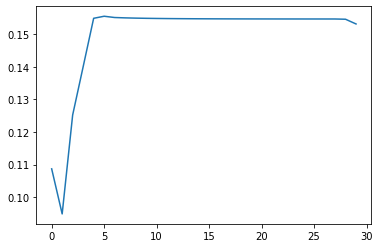

In [ ]:
plt.plot(np.arange(len(epoch_losses)), epoch_losses)

In [ ]:
test_index = 0
test_inputs = torchInputs[test_index-7:test_index,:]
test_outputs = {"spend_all": [], "revenue_all": [], "emp_combined": [] }
test_pred_outputs = {"spend_all": [], "revenue_all": [], "emp_combined": [] }
test_count = 30

predicted_outputs = np.empty(shape=(0,targets.shape[1],test_count))

state_i = 0

model.eval()
for state in states:
  test_index = df_covid_state.index.get_loc((state, "2020-09-01"))
  print(test_index)

  predicted_outputs_state = np.empty(shape=(targets.shape[1],test_count))
  date_count = df_covid_state.loc[state].shape[0]

  model.init_hidden(1)
  for i in range(6,test_index):
    model(torchInputs[np.arange(i-records_to_provide+1, i+1)])

  for i in range(test_count):

    with torch.no_grad():
        #model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
        #                torch.zeros(1, 1, model.hidden_layer_size))
        test_inputs = torchInputs[np.arange(test_index+i-records_to_provide+1, test_index+i+1),:]
        #if (i > 7):
          # If 107, replace day 100
          # If 108, replace day 100-101
          #print(predicted_outputs.shape)
          #print("Replacing index {0}-{1} known values with predicted values".format(0, i-7))
          #print(inputs[test_index-7:test_index-7+i-7, -targetsAL.shape[1]:])
          #print(torch.from_numpy(predicted_outputs[0:i-7,:]))
          #inputs[0:min(i-7,7), -targetsAL.shape[1]:] = torch.from_numpy(predicted_outputs[0:min(i-7,7),:])

        predictions = model(test_inputs.reshape([records_to_provide,-1]))
        #print(predicted_outputs.shape)
        #print(predictions.numpy().shape)
        predicted_outputs_state[:,i] = predictions.cpu().numpy()

        #print(predictions)
        #test_outputs.append(predictions.item())
        for col in test_outputs:
          test_outputs[col].append(torchTargets[test_index+i, df_econ_condensed.columns.get_loc(col)].item())

  predicted_outputs = np.append(predicted_outputs, predicted_outputs_state.reshape(1,targets.shape[1], test_count), axis=0)

  c=0
  for col in test_outputs:
    test_pred_outputs[col].extend(predicted_outputs[state_i,c,:].reshape((-1,)).tolist())
    #test_outputs[col].append(torchTargets[test_index, df_econ_condensed.columns.get_loc(col)].item())
    c+=1

  #test_index += date_count
  state_i += 1


#for col in test_outputs:
  #test_pred_outputs[col] = (predicted_outputs[:, df_econ_condensed.columns.get_loc(col), :].reshape((-1,)).tolist())

print(test_outputs)
print(test_pred_outputs)
print(len(test_outputs["spend_all"]))

203
{'spend_all': [0.7775061130523682, 0.8102689385414124, 0.8452322483062744, 0.8022004961967468, 0.8369193077087402, 1.0, 0.8679706454277039, 0.7497310638427734, 0.7508068680763245, 0.8022004961967468, 0.7770171165466309, 0.7466259002685547, 0.7051344513893127, 0.7109779715538025, 0.7218826413154602, 0.6352078318595886, 0.6295843720436096, 0.6872860789299011, 0.7131784558296204, 0.7378239631652832, 0.7416870594024658, 0.7520293593406677, 0.8474327921867371, 0.8484107851982117, 0.8447432518005371, 0.846943736076355, 0.841320276260376, 0.8261613845825195, 0.8188263773918152, 0.7694376707077026], 'revenue_all': [0.4053109586238861, 0.3895876705646515, 0.39133474230766296, 0.41754016280174255, 0.4088050425052643, 0.44199860095977783, 0.4874213933944702, 0.455974817276001, 0.45772188901901245, 0.5206149220466614, 0.517120897769928, 0.5345911979675293, 0.5398322939872742, 0.5101327896118164, 0.4489867389202118, 0.3633822798728943, 0.30922430753707886, 0.293501079082489, 0.28651294112205505

In [ ]:
from sklearn.metrics import r2_score, explained_variance_score

for col in test_outputs:
  r2 = r2_score(test_outputs[col], test_pred_outputs[col])
  print(r2)
  expvar = explained_variance_score(test_outputs[col], test_pred_outputs[col])
  print(expvar)

  meanobs = np.mean(test_outputs[col])
  nse = 1 - np.sum(np.power(np.array(test_pred_outputs[col]) - np.array(test_outputs[col]), 2)) / np.sum(np.power(np.array(test_outputs[col]) - meanobs, 2))
  print(nse)
  print()


-1.1729106193360348
1.437516694569041e-07
-1.1729106193360348

-0.625738695507501
-1.0001488000010994e-06
-0.625738695507501

-1.892347214236691
-3.7962414300984904e-07
-1.892347214236691



In [ ]:
#display(test_outputs)
#display(torchTargets[train_size:train_size+test_count])

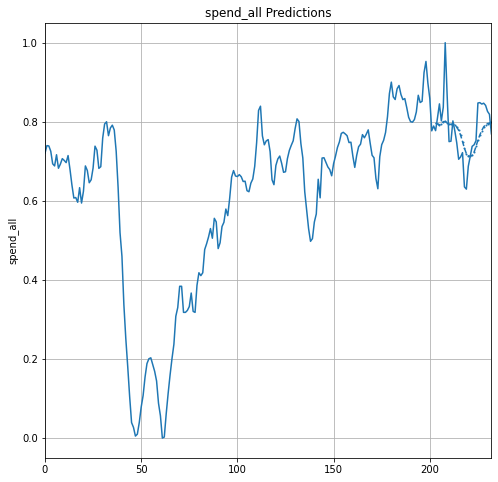

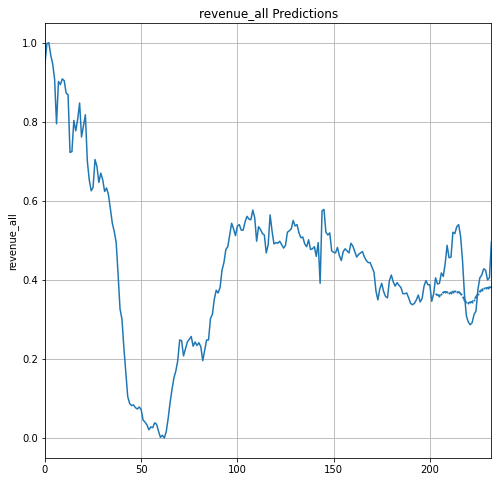

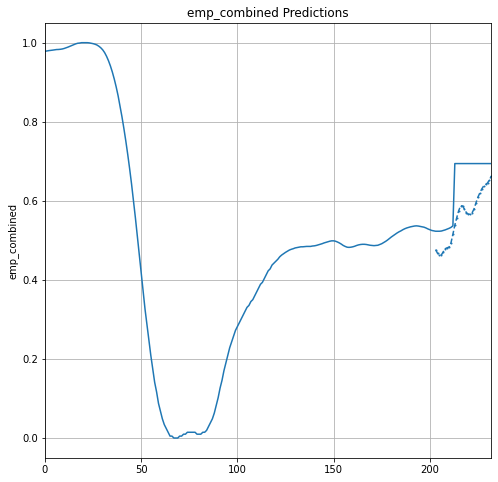

In [ ]:
col = 0
for column in test_outputs:
  plt.figure(figsize=(14,10))
  plt.title("{0} Predictions".format(column))
  plt.ylabel(column)
  plt.grid(True)
  plt.autoscale(axis='x', tight=True)

  train_size = df_covid_state.index.get_loc((1, "2020-09-01"))

  x=np.arange(0,train_size+test_count,step=1)
  #print(targets[column].iloc[0:2])

  #print(targets_normalized[:,0:5])

  i = 0
  state_i = 0
  row_index = 0

  for state in states:
    date_count = df_covid_state.loc[state].shape[0]
    if (True or state<6):
      #plt.plot(x, targetsAL_normalized[0:train_size+test_count, targetsAL.columns.get_loc(column)], color="b")
      plt.plot(x, torchTargets[row_index:row_index+train_size+test_count, df_econ_condensed.columns.get_loc(column)].cpu().numpy(), linestyle="-", color="C{0}".format(i))
      plt.plot(x[train_size:train_size+test_count], predicted_outputs[state_i, df_econ_condensed.columns.get_loc(column), 0:test_count], linestyle="--", marker="o", markersize=0, color="C{0}".format(i))

      i += 1
    state_i += 1
    row_index += date_count

  #plt.plot(np.arange(train_size,train_size+test_count), test_outputs[column], color="C1")
  plt.show()

  col += 1